<a href="https://colab.research.google.com/github/yaman3397/KGGDM_Deep_Learning/blob/main/KGGDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📋 Full Step-by-Step Implementation Plan for KGGDM

⸻

### Phase 1: Environment Setup

	1.	Set up Google Colab environment
Install required libraries:
	•	torch, torchvision, diffusers, transformers, accelerate
	•	pykeen (for TransE knowledge graph embeddings)
	•	torchmetrics (for evaluation metrics like FID, IS)
	•	timm (for classifier training, optional)
	•	(Optional) Mount Google Drive for saving models/checkpoints.

⸻

### Phase 2: Dataset Preparation (CelebA)
	2.	Download the CelebA dataset
	•	Use Kaggle API or alternative download link.
	•	Extract:
	•	img_align_celeba/ (images)
	•	list_attr_celeba.txt (attribute labels)
	3.	Preprocess the CelebA images
	•	Center-crop and resize all images to 256x256.
	•	Normalize images (scale pixel values from [0,255] to [-1,1]).
	4.	Load and parse attribute metadata
	•	Read list_attr_celeba.txt into a Pandas DataFrame.
	•	Each image has 40 binary attributes (+1 present, -1 absent).

⸻

### Phase 3: Knowledge Graph (KG) Construction
	5.	Design an ontology
	•	Group attributes into logical categories (Hair, Makeup, Accessories, etc.).
	6.	Build knowledge graph triples
	•	For each image and each attribute (where attribute=1):
	•	Create triples: (Image_ID, relation, Attribute).
	•	(Optional) Add ontology-level triples if needed.
	7.	Save all triples
	•	Prepare triples in a format compatible with PyKEEN (list or NumPy array).

⸻

### Phase 4: Knowledge Graph Embedding (TransE)
	8.	Train a TransE model using PyKEEN
	•	Feed KG triples to PyKEEN’s TriplesFactory.
	•	Train TransE model to learn entity/relation embeddings.
	•	Save the trained TransE model.
	9.	Extract attribute embeddings
	•	For each of the 40 CelebA attributes, extract its learned vector (d-dimensional, e.g., d=50).

⸻

### Phase 5: Feature Compaction (Autoencoder)
	10.	Construct per-image attribute vectors
	•	For each image:
	•	Multiply attribute embeddings by +1/-1 based on the attribute label.
	•	Concatenate into a single vector (shape: 40 × d).
	11.	Design an autoencoder
	•	Encoder: Compress 40×d input into a latent_dim vector (e.g., 128-dim).
	•	Decoder: Reconstruct the original 40×d vector.
	12.	Train the autoencoder
	•	Minimize reconstruction error (MSE loss).
	•	Save the trained autoencoder model.
	13.	Compress attribute vectors
	•	Pass the per-image attribute vectors through the autoencoder encoder to obtain compressed 128-dim vectors.

⸻

### Phase 6: Stable Diffusion Modification
	14.	Load a pre-trained Stable Diffusion model
	•	Use Hugging Face’s diffusers library (runwayml/stable-diffusion-v1-5 or similar).
	15.	Add a conditioning projection layer
	•	Project compressed 128-dim vectors to 768-dim (the dimension used for cross-attention conditioning).
	16.	Prepare latent-space training data
	•	Encode images using the VAE encoder to obtain latents.
	•	Match each latent with its compressed attribute conditioning vector.

⸻

### Phase 7: Fine-tuning the Diffusion Model
	17.	Train Stable Diffusion with KG conditioning
	•	Add noise to latents based on random timesteps.
	•	Train U-Net to predict noise conditioned on KG attribute embeddings.
	•	Use MSE loss between predicted and true noise.
	•	Train U-Net + projection layer.
	18.	Save the fine-tuned model
	•	Save updated U-Net weights and projection layer.

⸻

### Phase 8: Inference (Image Generation)
	19.	Generate images
	•	Given a desired set of attributes (Smiling, Male, Blond Hair, etc.):
	•	Build attribute vector → Compress → Project to 768-dim → Condition diffusion model.
	•	Generate and save images.

⸻

### Phase 9: Evaluation
	20.	Evaluate with FID and IS
	•	Generate a batch of fake images.
	•	Compare with real CelebA images to compute:
	•	Fréchet Inception Distance (FID).
	•	Inception Score (IS).
	21.	Evaluate conditional attribute accuracy
	•	Train a simple classifier (ResNet50 or similar) to predict attributes.
	•	Check if generated images match requested attributes.

⸻

### Phase 10: Ablation Studies
	22.	Train baselines for comparison
	•	Unconditional diffusion model (no attribute conditioning).
	•	Attribute-conditioned diffusion without KG embeddings (using raw attributes directly).
	23.	Compare results
	•	FID, IS, and conditional accuracy.
	•	Show that KG conditioning improves controllability and image quality.

⸻

### ✅ Summary of the 23 Key Steps:
	•	1-4: Dataset preparation
	•	5-7: Knowledge graph construction
	•	8-9: Train TransE
	•	10-13: Train Autoencoder
	•	14-16: Load and modify Stable Diffusion
	•	17-18: Fine-tune diffusion model
	•	19: Inference (generation)
	•	20-21: Evaluation
	•	22-23: Ablation study

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
### 1. Download DataSet from Keggle

In [7]:
# Install gdown for Google Drive downloads
!pip install -q gdown

import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T

# ─── 1. Point to your raw folder ───────────────────────────────────────────────
raw_dir = Path(r"/content/drive/MyDrive/content/celebA")
img_dir = raw_dir / "img_align_celeba/img_align_celeba"

# ─── 2. Locate the CSV and peek at it ──────────────────────────────────────────
attr_csv = raw_dir / "list_attr_celeba.csv"   # picks up your CSV
print("Using attributes file:", attr_csv.name)
df_attrs = pd.read_csv(attr_csv, index_col=0)
print(df_attrs.head())


Using attributes file: list_attr_celeba.csv
            5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
image_id                                                                     
000001.jpg                -1                1           1               -1   
000002.jpg                -1               -1          -1                1   
000003.jpg                -1               -1          -1               -1   
000004.jpg                -1               -1           1               -1   
000005.jpg                -1                1           1               -1   

            Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  Blond_Hair  ...  \
image_id                                                             ...   
000001.jpg    -1     -1        -1        -1          -1          -1  ...   
000002.jpg    -1     -1        -1         1          -1          -1  ...   
000003.jpg    -1     -1         1        -1          -1          -1  ...   
000004.jpg    -1     -1      

In [9]:
# If values are -1 / +1, convert to 0 / 1:
if set(np.unique(df_attrs.values)) <= {-1, 1}:
    df_attrs = ((df_attrs + 1) // 2).astype(int)

print(f"\nFinal attribute table: {df_attrs.shape[0]} images × {df_attrs.shape[1]} attrs")


Final attribute table: 202599 images × 40 attrs


In [13]:
from PIL import Image
import torchvision.transforms as transforms
import torch
from torch.utils.data import Dataset

#	•	We center-crop the face (CelebA images are originally 178x218).
#	•	Then resize to 256×256.
#	•	Finally, normalize to [-1, 1] (standard for Stable Diffusion and VAEs).

# Define transform
preprocess_transform = transforms.Compose([
    transforms.CenterCrop(178),        # center-crop square
    transforms.Resize((256, 256)),      # resize to 256x256
    transforms.ToTensor(),              # convert [0,255] PIL image to [0,1] tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # normalize [0,1] → [-1,1]
])

In [14]:
# ─── 4. Dataset class ──────────────────────────────────────────────────────────
class CelebACSV(Dataset):
    def __init__(self, img_folder: Path, attrs: pd.DataFrame, transform=None):
        self.img_folder = img_folder
        self.attrs = attrs
        self.names = [f"{int(n):06}.jpg" if not str(n).endswith('.jpg') else n for n in attrs.index]
        self.transform = transform

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        name = self.names[idx]
        path = self.img_folder / name
        if not path.exists():
            raise FileNotFoundError(f"Missing file: {path}")

        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        lbl = torch.tensor(self.attrs.loc[name].values, dtype=torch.float32)
        return img, lbl, name

In [16]:
# ─── 5. Instantiate & test ────────────────────────────────────────────────────
dataset = CelebACSV(img_dir, df_attrs, transform=preprocess_transform) # Changed preprocess to preprocess_transform
print(f"Dataset ready with {len(dataset)} samples.")

Dataset ready with 202599 samples.


In [19]:
# ─── 6. Visualize one random example ──────────────────────────────────────────
idx = np.random.randint(len(dataset))
print(f"Random index: {idx}")
img_t, lbl_t, fname = dataset[idx]

# undo normalization for display
img_disp = img_t.mul(0.5).add(0.5).clamp(0,1)
img_np   = img_disp.permute(1,2,0).cpu().numpy()
plt.figure(figsize=(4,4))
plt.imshow(img_np)
plt.axis('off')
plt.title(fname)
plt.show()

Random index: 131594


KeyboardInterrupt: 

In [22]:
## TO comapre with the dummy code ; docx

relation_map = {
    # Hair Color
    "Black_Hair": "hasHairColor",
    "Blond_Hair": "hasHairColor",
    "Brown_Hair": "hasHairColor",
    "Gray_Hair": "hasHairColor",

    # Hair Style
    "Bald": "hasHairStyle",
    "Bangs": "hasHairStyle",
    "Receding_Hairline": "hasHairStyle",
    "Straight_Hair": "hasHairStyle",
    "Wavy_Hair": "hasHairStyle",

    # Facial Hair
    "5_o_Clock_Shadow": "hasFacialHair",
    "Mustache": "hasFacialHair",
    "Goatee": "hasFacialHair",
    "Sideburns": "hasFacialHair",
    "No_Beard": "hasFacialHair",

    # Facial Features
    "Arched_Eyebrows": "hasFacialFeature",
    "Bushy_Eyebrows": "hasFacialFeature",
    "High_Cheekbones": "hasFacialFeature",
    "Narrow_Eyes": "hasFacialFeature",
    "Big_Nose": "hasFacialFeature",
    "Big_Lips": "hasFacialFeature",
    "Pointy_Nose": "hasFacialFeature",
    "Oval_Face": "hasFacialFeature",
    "Double_Chin": "hasFacialFeature",
    "Chubby": "hasFacialFeature",

    # Accessories
    "Eyeglasses": "wearsAccessory",
    "Wearing_Hat": "wearsAccessory",
    "Wearing_Earrings": "wearsAccessory",
    "Wearing_Necklace": "wearsAccessory",
    "Wearing_Necktie": "wearsAccessory",

    # Makeup
    "Heavy_Makeup": "wearsMakeup",
    "Wearing_Lipstick": "wearsMakeup",

    # Demographics
    "Male": "hasGender",
    "Young": "hasAgeGroup",

    # Expression
    "Smiling": "hasExpression",
    "Mouth_Slightly_Open": "hasExpression",

    # Skin Features
    "Bags_Under_Eyes": "hasSkinFeature",
    "Pale_Skin": "hasSkinFeature",
    "Rosy_Cheeks": "hasSkinFeature",

    # Other (special case)
    "Blurry": "hasImageQuality",
    "Attractive": "hasAttractiveness"
}

In [23]:
## TO comapre with the dummy code ; docx

relation_map_2 = {
    ### id of the image
    "Image": "ID",
    # Hair Color
    "Black_Hair": "hasHairColor",
    "Blond_Hair": "hasHairColor",
    "Brown_Hair": "hasHairColor",
    "Gray_Hair": "hasHairColor",

    # Hair Style
    "Bald": "hasHairStyle",
    "Bangs": "hasHairStyle",
    "Receding_Hairline": "hasHairStyle",
    "Straight_Hair": "hasHairStyle",
    "Wavy_Hair": "hasHairStyle",

    # Facial Hair
    "5_o_Clock_Shadow": "hasFacialHair",
    "Mustache": "hasFacialHair",
    "Goatee": "hasFacialHair",
    "Sideburns": "hasFacialHair",
    "No_Beard": "hasFacialHair",

    # Facial Features
    "Arched_Eyebrows": "hasFacialFeature",
    "Bushy_Eyebrows": "hasFacialFeature",
    "High_Cheekbones": "hasFacialFeature",
    "Narrow_Eyes": "hasFacialFeature",
    "Big_Nose": "hasFacialFeature",
    "Big_Lips": "hasFacialFeature",
    "Pointy_Nose": "hasFacialFeature",
    "Oval_Face": "hasFacialFeature",
    "Double_Chin": "hasFacialFeature",
    "Chubby": "hasFacialFeature",

    # Accessories
    "Eyeglasses": "wearsAccessory",
    "Wearing_Hat": "wearsAccessory",
    "Wearing_Earrings": "wearsAccessory",
    "Wearing_Necklace": "wearsAccessory",
    "Wearing_Necktie": "wearsAccessory",

    # Makeup
    "Heavy_Makeup": "wearsMakeup",
    "Wearing_Lipstick": "wearsMakeup",

    # Demographics
    "Male": "hasGender",
    "Young": "hasAgeGroup",

    # Expression
    "Smiling": "hasExpression",
    "Mouth_Slightly_Open": "hasExpression",

    # Skin Features
    "Bags_Under_Eyes": "hasSkinFeature",
    "Pale_Skin": "hasSkinFeature",
    "Rosy_Cheeks": "hasSkinFeature",

    # Other (special case)
    "Blurry": "hasImageQuality",
    "Attractive": "hasAttractiveness"
}

In [24]:
triples = []

for idx, row in dataset.attrs.iterrows():
    img_id = idx.split(".")[0]  # "000001" from "000001.jpg"
    img_entity = f"Image_{img_id}"  # e.g., Image_000001

    for attr_name, value in row.items():
        if value == 1:  # Attribute is present
            relation = relation_map.get(attr_name, "hasAttribute")  # default fallback relation
            triples.append((img_entity, relation, attr_name))

In [25]:
print(f"Total Triples Generated: {len(triples)}")
print(f"Example Triple: {triples[0]}")

Total Triples Generated: 1830201
Example Triple: ('Image_000001', 'hasFacialFeature', 'Arched_Eyebrows')


In [26]:
# ─── 1) A true 4-level ontology ────────────────────────────────────────────────
ontology = {
    # Category: { Relation: [ attributes... ] }
    "Demographics": {
        "hasGender":        ["Male"],
        "hasAgeGroup":      ["Young"],
        "hasAttractiveness":["Attractive"],
    },
    "Hair": {
        "hasHairColor":     ["Black_Hair", "Blond_Hair", "Brown_Hair", "Gray_Hair"],
        "hasHairStyle":     ["Bald", "Bangs", "Straight_Hair",
                             "Wavy_Hair", "Receding_Hairline"],
    },
    "Facial Hair": {
        "hasFacialHair":    ["5_o_Clock_Shadow", "Mustache",
                             "Goatee", "No_Beard", "Sideburns"],
    },
    "Facial Features": {
        "hasFacialFeature": ["Arched_Eyebrows", "Bushy_Eyebrows",
                             "High_Cheekbones", "Narrow_Eyes",
                             "Big_Nose", "Big_Lips", "Pointy_Nose",
                             "Oval_Face", "Double_Chin", "Chubby"],
    },
    "Makeup/Accessories": {
        "wearsMakeup":      ["Heavy_Makeup", "Wearing_Lipstick"],
        "wearsAccessory":   ["Eyeglasses", "Wearing_Earrings",
                             "Wearing_Hat", "Wearing_Necklace",
                             "Wearing_Necktie"],
    },
    "Expression/Others": {
        "hasExpression":    ["Smiling", "Mouth_Slightly_Open"],
        "hasSkinFeature":   ["Bags_Under_Eyes", "Rosy_Cheeks", "Pale_Skin"],
        "hasImageQuality":  ["Blurry"],
    }
}

Missing in relation_map: set()


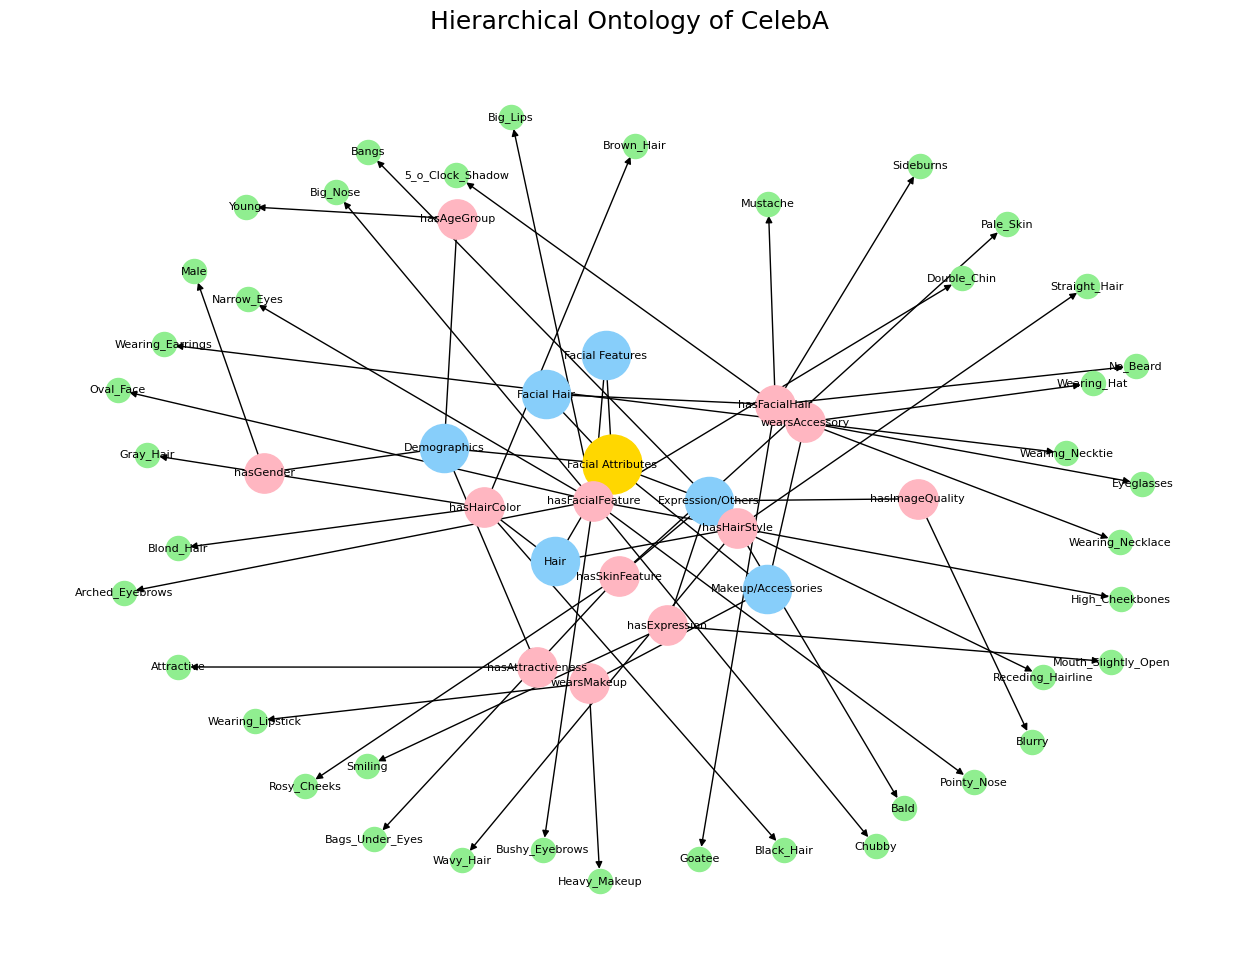

In [27]:
import networkx as nx
# ─── 2) Flatten to attr → relation for your KG triples ────────────────────────
relation_map = {
    attr: rel
    for cat, sub in ontology.items()
    for rel, attrs in sub.items()
    for attr in attrs
}

# Example check: should cover all 40 attributes without KeyErrors
missing = set(df_attrs.columns) - set(relation_map)
print("Missing in relation_map:", missing)   # should be empty

# ─── 3) Rebuild & visualize the 4-level tree ─────────────────────────────────
root = "Facial Attributes"
tree = nx.DiGraph()
tree.add_node(root)

for category, subcats in ontology.items():
    tree.add_edge(root, category)
    for relation, attrs in subcats.items():
        tree.add_edge(category, relation)
        for a in attrs:
            tree.add_edge(relation, a)

# Layout (Graphviz dot is ideal, fallback to spring)
try:
    from networkx.drawing.nx_agraph import graphviz_layout
    pos = graphviz_layout(tree, prog="dot")
except ImportError:
    pos = nx.spring_layout(tree, seed=42, k=0.5)

plt.figure(figsize=(16, 12))
# classify nodes by depth
level0 = [root]
level1 = list(ontology.keys())
level2 = [r for sub in ontology.values() for r in sub]
level3 = [a for sub in ontology.values() for attrs in sub.values() for a in attrs]

nx.draw_networkx_nodes(tree, pos, nodelist=level0,  node_color="#FFD700", node_size=1800)
nx.draw_networkx_nodes(tree, pos, nodelist=level1,  node_color="#87CEFA", node_size=1200)
nx.draw_networkx_nodes(tree, pos, nodelist=level2,  node_color="#FFB6C1", node_size=800)
nx.draw_networkx_nodes(tree, pos, nodelist=level3,  node_color="#90EE90", node_size=300)

nx.draw_networkx_edges(tree, pos, arrows=True, arrowstyle="-|>", arrowsize=10, width=1)
nx.draw_networkx_labels(tree, pos, font_size=8)

plt.title("Hierarchical Ontology of CelebA", fontsize=18)
plt.axis("off")
plt.show()

In [28]:
triples = []
for img_id, row in df_attrs.iterrows():
    img_entity = f"Image_{img_id.split('.')[0]}"
    for attr, val in row.items():
        if val == 1:
            rel = relation_map[attr]
            triples.append((img_entity, rel, attr))

print(f"Generated {len(triples)} image→attribute triples.")

Generated 1830201 image→attribute triples.


In [29]:
pip install pykeen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.3/730.3 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [30]:
from pathlib import Path
from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline
import torch
triples_array = np.array(triples, dtype=np.object_)

INFO:pykeen.utils:Using opt_einsum


In [31]:
# ─── B) Build a TriplesFactory ────────────────────────────────────────────────
tf = TriplesFactory.from_labeled_triples(
    triples_array,
    create_inverse_triples=False       # you can set True if you want inverse relations
)
print(f"Entities:  {tf.num_entities}")
print(f"Relations: {tf.num_relations}")
print(f"Triples:   {tf.num_triples:,}")


Entities:  202639
Relations: 12
Triples:   1,830,201


In [32]:
# ─── C) Train a TransE model via the high-level pipeline ───────────────────────

In [33]:
training, validation, testing = tf.split(
    ratios=[0.8, 0.1, 0.1],
    random_state=42,
)

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [1261541, 183020, 183021]


In [34]:
training, validation, testing = tf.split(
    ratios=[0.8, 0.1, 0.1],
    random_state=42,
)
from pykeen.pipeline import pipeline

result = pipeline(
    # your splits
    training=training,
    validation=validation,
    testing=testing,

    # model specs
    model='TransE',
    model_kwargs=dict(
        embedding_dim=50,
        scoring_fct_norm=1,
    ),

    # optimizer specs are top-level, not inside training_kwargs
    optimizer='Adam',
    optimizer_kwargs=dict(
        lr=1e-3,
    ),

    # only num_epochs, batch_size, checkpoint_name go here
    training_kwargs=dict(
        num_epochs=50,
        batch_size=512,
        checkpoint_name=None,
    ),

    device='cuda' if torch.cuda.is_available() else 'cpu',
    random_seed=42,
)


INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [1261541, 183020, 183021]
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()


Training epochs on cuda:0:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/183k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 444.94s seconds


In [35]:
# ─── D) Save the trained model to disk ─────────────────────────────────────────
out_dir = Path("transE_celeba_3")
result.save_to_directory(out_dir)
print(f"Model and training artifacts saved to {out_dir}")

INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=202639, num_relations=12, create_inverse_triples=False, num_triples=1464160) to file:///content/transE_celeba_3/training_triples
INFO:pykeen.pipeline.api:Saved to directory: /content/transE_celeba_3


Model and training artifacts saved to transE_celeba_3


In [36]:
import os
print(os.listdir("transE_celeba_3"))


['trained_model.pkl', 'training_triples', 'metadata.json', 'results.json']


In [37]:
import torch
import numpy as np

# 1) Grab the representation module
rep = result.model.entity_representations[0]

# 2) Make a tensor of all entity IDs
num_entities = tf.num_entities
all_ids = torch.arange(num_entities, dtype=torch.long)

# 3) Call the module to get all embeddings at once
#    Shape will be [num_entities, embedding_dim]
with torch.no_grad():
    weights = rep(all_ids).cpu().numpy()

print("weights.shape:", weights.shape)  # e.g. (202639, 50)

# 4) Build your 40×50 attribute‐only matrix
ent2id     = tf.entity_to_id
attr_names = list(df_attrs.columns)    # your 40 attribute names
attr_embeddings = np.vstack([weights[ent2id[a]] for a in attr_names])
print("attr_embeddings.shape:", attr_embeddings.shape)  # (40, 50)


weights.shape: (202639, 50)
attr_embeddings.shape: (40, 50)


In [38]:
##  Build your per–image vectors

In [39]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# attr_embeddings: NumPy array shape (40, 50)
attr_emb_t = torch.from_numpy(attr_embeddings)       # [40, 50]

# Build a list of per–image vectors
vectors = []
for img_name, row in df_attrs.iterrows():
    # row is series of 0/1 labels for the 40 attrs
    labels = torch.tensor(row.values, dtype=torch.float32)  # [40]
    # multiply each attr embedding by its label and flatten
    vec = (labels.unsqueeze(1) * attr_emb_t).view(-1)       # [40*50]
    vectors.append(vec)

# Stack into one big tensor [N_images, 2000]
X = torch.stack(vectors)
print("Per‐image matrix X:", X.shape)
# Wrap as a DataLoader for training
dataset_ae = TensorDataset(X, X)
loader = DataLoader(dataset_ae, batch_size=256, shuffle=True)


Per‐image matrix X: torch.Size([202599, 2000])


## Build autoencoder

In [40]:
import torch.nn as nn

class AttrAutoencoder(nn.Module):
    def __init__(self, input_dim=2000, latent_dim=128):
        super().__init__()
        # encoder: 2000 → 512 → 128
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, latent_dim),
        )
        # decoder: 128 → 512 → 2000
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, input_dim),
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z



In [43]:
# 2) Decide split sizes
from torch.utils.data import random_split, DataLoader, TensorDataset
import torch.nn as nn # Import nn here if not already imported in a shared cell

total = len(X)
train_size = int(0.8 * total)
val_size   = total - train_size

# 3) Perform the split (with a fixed seed for reproducibility)
torch.manual_seed(42)
train_ds, val_ds = random_split(
    TensorDataset(X, X),
    [train_size, val_size]
)

# 4) Create DataLoaders
batch_size = 256
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size)

print(f"Train samples: {len(train_ds)}, Val samples: {len(val_ds)}")

# Instantiate the Autoencoder model
autoenc = AttrAutoencoder(input_dim=X.shape[1], latent_dim=128)
print("Autoencoder instantiated.")

Train samples: 162079, Val samples: 40520
Autoencoder instantiated.


## Train Autoencoder

In [44]:
# 5) Example training loop with both train & val loss
import torch.nn as nn, torch.optim as optim

device   = "cuda" if torch.cuda.is_available() else "cpu"
autoenc = autoenc.to(device)
optimizer = optim.Adam(autoenc.parameters(), lr=1e-3)
criterion = nn.MSELoss()

num_epochs = 10
for epoch in range(1, num_epochs+1):
    # — Train —
    autoenc.train()
    train_loss = 0.0
    for xb, _ in train_loader:
        xb = xb.to(device)
        optimizer.zero_grad()
        x_hat, _ = autoenc(xb)
        loss = criterion(x_hat, xb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= train_size

    # — Validate —
    autoenc.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, _ in val_loader:
            xb = xb.to(device)
            x_hat, _ = autoenc(xb)
            val_loss += criterion(x_hat, xb).item() * xb.size(0)
    val_loss /= val_size

    print(f"Epoch {epoch:2d} | Train MSE: {train_loss:.6f} | Val MSE: {val_loss:.6f}")

Epoch  1 | Train MSE: 0.000203 | Val MSE: 0.000003
Epoch  2 | Train MSE: 0.000012 | Val MSE: 0.000008
Epoch  3 | Train MSE: 0.000010 | Val MSE: 0.000003
Epoch  4 | Train MSE: 0.000008 | Val MSE: 0.000005
Epoch  5 | Train MSE: 0.000007 | Val MSE: 0.000008
Epoch  6 | Train MSE: 0.000006 | Val MSE: 0.000003
Epoch  7 | Train MSE: 0.000005 | Val MSE: 0.000004
Epoch  8 | Train MSE: 0.000005 | Val MSE: 0.000002
Epoch  9 | Train MSE: 0.000004 | Val MSE: 0.000004
Epoch 10 | Train MSE: 0.000004 | Val MSE: 0.000005


## Extrace compressed vectors

-- 128-dim representation for each CelebA image, ready to be projected into the Stable Diffusion conditioning space

In [45]:
torch.save(autoenc.state_dict(), "attr_autoencoder.pth")

In [46]:
autoenc.eval()
all_z = []
with torch.no_grad():
    for xb, _ in loader:
        xb = xb.to(device)
        _, z = autoenc(xb)
        all_z.append(z.cpu())
all_z = torch.cat(all_z, dim=0)  # [N_images, 128]
print("Compressed features:", all_z.shape)
# Optionally save
import numpy as np
np.save("compressed_attr_vectors.npy", all_z.numpy())


Compressed features: torch.Size([202599, 128])


### Stable Diffusion

In [47]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler

In [48]:
# ─── 1) Load pretrained Stable Diffusion ─────────────────────────────────────
vae = AutoencoderKL.from_pretrained(
    "runwayml/stable-diffusion-v1-5", subfolder="vae"
).to(device)
unet = UNet2DConditionModel.from_pretrained(
    "runwayml/stable-diffusion-v1-5", subfolder="unet"
).to(device)
scheduler = DDPMScheduler.from_pretrained(
    "runwayml/stable-diffusion-v1-5", subfolder="scheduler"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

In [49]:
# Freeze VAE
for p in vae.parameters():
    p.requires_grad = False

In [50]:
# ─── 2) Add a projection from 128 → 768 ───────────────────────────────────────
proj = nn.Linear(128, unet.config.cross_attention_dim).to(device)

In [51]:
import torch
from torch.utils.data import Dataset, DataLoader

class LatentAttributeDataset(Dataset):
    def __init__(self, image_dataset, attr_codes, vae, scheduler, proj, device):
        """
        image_dataset: your CelebACSV instance (returns img_tensor in [-1,1])
        attr_codes:     Tensor [N_images, 128] of compressed codes
        vae:            your AutoencoderKL
        scheduler:      your DDPMScheduler
        proj:           nn.Linear(128,768) projection head
        device:         "cuda" or "cpu"
        """
        self.image_ds   = image_dataset
        self.attr_codes = attr_codes
        self.vae        = vae
        self.scheduler  = scheduler
        self.proj       = proj
        self.device     = device

    def __len__(self):
        return len(self.image_ds)

    def __getitem__(self, idx):
        # 1) load & normalize the image [-1,1]
        img, _, _ = self.image_ds[idx]                        # [3,256,256]
        img = img.unsqueeze(0).to(self.device)                # [1,3,256,256]

        # 2) get its 128-d code
        code = self.attr_codes[idx].to(self.device)           # [128]

        # 3) encode to VAE latents
        with torch.no_grad():
            latents = self.vae.encode(img).latent_dist.sample()
            latents = latents * self.vae.config.scaling_factor

        # 4) pick a random timestep + noise
        t = torch.randint(
            0, self.scheduler.num_train_timesteps,
            (1,), device=self.device
        ).long()
        noise = torch.randn_like(latents)
        noisy_latents = self.scheduler.add_noise(latents, noise, t)

        # 5) project the code into cross-attention dim
        cond = self.proj(code).unsqueeze(0)                   # [1,768]

        # squeeze batch‐dim on latents/noise so DataLoader sees [C,H,W]
        return (
            noisy_latents.squeeze(0),  # [C,H,W]
            t.squeeze(0),              # scalar
            noise.squeeze(0),          # [C,H,W]
            cond.squeeze(0),           # [768]
        )



In [52]:
# ─── Instantiate it ─────────────────────────────────────────────────────────────
device   = "cuda" if torch.cuda.is_available() else "cpu"
proj     = proj.to(device)  # your nn.Linear(128,768)
dataset_sd = LatentAttributeDataset(dataset, all_z, vae, scheduler, proj, device)
loader_sd  = DataLoader(dataset_sd, batch_size=16, shuffle=True, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [53]:
num_epochs = 10
ckpt_dir   = Path("sd_finetuned")
ckpt_dir.mkdir(exist_ok=True)

mse_loss = nn.MSELoss()

In [ ]:
# Set the multiprocessing start method to 'spawn' if running on CUDA and it's not already set
# This needs to be done BEFORE the DataLoader is created
import torch
if torch.cuda.is_available() and torch.multiprocessing.get_start_method(allow_none=True) != 'spawn':
    torch.multiprocessing.set_start_method('spawn', force=True)
    print("Set multiprocessing start method to 'spawn'")

# Wrap the training loop within if __name__ == '__main__':
if __name__ == '__main__':
    # Ensure device, unet, proj, scheduler, mse_loss, optimizer, num_epochs, ckpt_dir, loader_sd are defined
    # (Assuming these were defined in preceding blocks and are available)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # --- Placeholder Definitions (Replace with your actual loaded/defined objects) ---
    # This section is just for context; your actual objects should be defined earlier.
    # from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler
    # import torch.nn as nn
    # from pathlib import Path
    # import torch.optim as optim
    # from torch.utils.data import DataLoader, Dataset, TensorDataset
    # import numpy as np

    # vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae").to(device)
    # unet = UNet2DConditionModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="unet").to(device)
    # scheduler = DDPMScheduler.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="scheduler")
    # proj = nn.Linear(128, unet.config.cross_attention_dim).to(device) # Ensure proj is defined and on device
    # mse_loss = nn.MSELoss()
    # num_epochs = 10
    # ckpt_dir = Path("sd_finetuned")
    # ckpt_dir.mkdir(exist_ok=True)

    # # Simple dataset class adjusted to return CPU tensors
    # class SimpleLatentAttributeDataset(Dataset):
    #     def __init__(self, image_dataset, attr_codes):
    #         self.image_ds   = image_dataset # This should be your CelebACSV dataset instance
    #         self.attr_codes = attr_codes # This should be your all_z tensor on CPU

    #     def __len__(self):
    #         return len(self.image_ds)

    #     def __getitem__(self, idx):
    #         img, _, _ = self.image_ds[idx] # [3,256,256], CPU tensor [-1,1]
    #         code = self.attr_codes[idx]    # [128], CPU tensor
    #         return img, code

    # # Assuming dataset and all_z are available from previous steps
    # # dataset = CelebACSV(...) # Your CelebA dataset instance
    # # all_z = torch.from_numpy(np.load("compressed_attr_vectors.npy")) # Load compressed vectors

    # # Create DataLoader with num_workers > 0
    # loader_sd  = DataLoader(dataset_sd, batch_size=16, shuffle=True, num_workers=4) # Use the SimpleLatentAttributeDataset instance

    # # Define the optimizer (targetting unet and proj parameters)
    # optimizer = optim.Adam([
    #     {'params': unet.parameters()},
    #     {'params': proj.parameters()}
    # ], lr=1e-4)
    # # --- End Placeholder Definitions ---


    # —––––– Training Loop —–––––
    from tqdm.auto import tqdm # Import tqdm for progress bar

    for epoch in range(1, num_epochs+1):
        epoch_loss = 0.0
        # Use the loader_sd created with num_workers > 0
        progress = tqdm(loader_sd, desc=f"Epoch {epoch}/{num_epochs}", leave=False)

        # Iterate through the DataLoader
        # The items received here (img, code) should be CPU tensors from the worker
        for img, code in progress:
            # Move data to the correct device HERE, in the main process
            img  = img.to(device)  # [B, 3, 256, 256]
            code = code.to(device) # [B, 128]

            # Perform VAE encoding, noise addition, and projection HERE
            # These operations should be on the device
            with torch.no_grad(): # VAE is frozen
                 latents = vae.encode(img).latent_dist.sample()
                 latents = latents * vae.config.scaling_factor # [B, C, H, W]

            # Pick random timesteps + noise for the batch
            t = torch.randint(
                0, scheduler.num_train_timesteps,
                (latents.shape[0],), device=device
            ).long()
            noise = torch.randn_like(latents)
            noisy_latents = scheduler.add_noise(latents, noise, t)

            # Project the code into cross-attention dim
            cond = proj(code) # [B, 768]

            # 1) Forward pass through U-Net
            out = unet(
                noisy_latents,
                t, # Use the batch of timesteps
                encoder_hidden_states=cond
            ).sample  # shape [B, C, H, W]

            # 2) Compute noise-prediction loss
            loss = mse_loss(out, noise)
            epoch_loss += loss.item() * noisy_latents.size(0)

            # 3) Backpropagate
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            progress.set_postfix(loss=loss.item())

        avg_loss = epoch_loss / len(loader_sd.dataset)
        print(f"Epoch {epoch} completed — Avg MSE: {avg_loss:.6f}")

        # 4) Save a checkpoint
        torch.save({
            "unet_state_dict": unet.state_dict(),
            "proj_state_dict": proj.state_dict(),
            "optimizer":       optimizer.state_dict(),
            "epoch":           epoch,
        }, ckpt_dir / f"epoch_{epoch:02d}.pt")

    print("✅ Fine-tuning complete and checkpoints saved to", ckpt_dir)

Set multiprocessing start method to 'spawn'
